# CS-GY 9223-D: Deep Learning Homework 2
Due on Friday, 12th March 2019, 11:55 PM

This homework can be done in pairs.

Write down the UNIs (NetIDs) of your group (if applicable)

Member 1: Name, NetID

Member 2: Name, NetID

### Create validation data

In [1]:
import os
import numpy as np
import glob

In [2]:
data_path = '../input/'
TRAIN = '../input/images_training_rev1/images_training_rev1'
TEST = '../input/images_test_rev1/images_test_rev1'
LABELS = '../input/training_solutions_rev1/training_solutions_rev1.csv'

# g = glob.glob(data_path+'train/*.jpg')
# shuf = np.random.permutation(g)
# for i in range(2000):
#     os.rename(shuf[i], data_path+ 'valid/' + shuf[i].split("/")[-1])

## Building VGG model in Keras

In [3]:
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda, Reshape
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Conv2D, MaxPooling2D, Activation
from keras.optimizers import SGD, RMSprop, Adam

import matplotlib.pylab as plt
%matplotlib inline

Using TensorFlow backend.


In [4]:
def ConvBlock(layers, model, filters):
    """
    Create a layered Conv/Pooling block
    """
    for i in range(layers): 
        model.add(ZeroPadding2D((1,1)))  # zero padding of size 1
        model.add(Convolution2D(filters, 3, 3, activation='relu'))  # 3x3 filter size 
    model.add(MaxPooling2D((1,1), strides=(2,2)))

def FCBlock(model):
    """
    Fully connected block with ReLU and dropout
    """
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    
def VGG_16():
    """
    Implement VGG16 architecture
    """
    model = Sequential()
    model.add(Lambda(lambda x : x, input_shape=(3,106,106)))
    
    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)

    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    
    model.add(Dense(37, activation = 'sigmoid'))
    return model

# Compile 
optimizer = RMSprop(lr=1e-6)
model = VGG_16()
model.compile(loss='mean_squared_error', optimizer=optimizer)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  import sys
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
  import sys
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), activation="relu")`
  import sys
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (3, 3), activation="relu")`
  import sys


In [5]:
from random import shuffle
from scipy.misc import imresize  

class data_getter:    
    """
    Creates a class for handling train/valid/test data paths,
    training labels and image IDs.
    Useful for switching between sample and full datasets.
    """
    def __init__(self, path):    
        self.path = path 
        self.train_path = TRAIN
        #self.val_path = path + "valid"
        self.test_path = TEST
        
        def get_paths(directory):
            return [f for f in os.listdir(directory)]
        
        self.training_images_paths = get_paths(self.train_path)
        #self.validation_images_paths = get_paths(self.val_path)
        self.test_images_paths = get_paths(self.test_path)    
        
        def get_all_solutions():
        ### Import solutions file and load into self.solutions
            import csv
            all_solutions = {}
            #/'training_solutions_rev1.csv'
            with open(LABELS, 'r') as f:
                reader = csv.reader(f, delimiter=",")
                next(reader)
                for i, line in enumerate(reader):
                    all_solutions[line[0]] = [float(x) for x in line[1:]]
            return all_solutions
        
        self.all_solutions = get_all_solutions()

    def get_id(self,fname):
        return fname.replace(".jpg","").replace("data","")
        
    def find_label(self,val):
        return self.all_solutions[val]
        
# fetcher = data_getter('data/sample/')
fetcher = data_getter(data_path)
print(fetcher.train_path)

../input/images_training_rev1/images_training_rev1


In [6]:
def process_images(paths):
    """
    Import image at 'paths', decode, centre crop and prepare for batching. 
    """
    count = len(paths)
    arr = np.zeros(shape=(count,3,106,106))
    for c, path in enumerate(paths):
        img = plt.imread(path).T
        img = img[:,106:106*3,106:106*3] #crop 424x424 -> 212x212
        img = imresize(img,size=(106,106,3),interp="cubic").T # downsample to half res
        arr[c] = img
    return arr

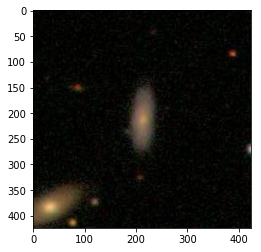

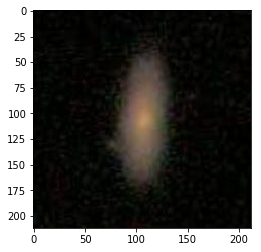

In [7]:
## Print some before/after processing images

#process_images([fetcher.train_path + '/' + fetcher.training_images_paths[100]])
im = plt.imread(fetcher.train_path + '/' + fetcher.training_images_paths[0])
# print(im.shape)

plt.imshow(im)
plt.show()
im = im.T[:,106:106*3,106:106*3] #crop 424x424 -> 212x212

plt.imshow(im.T)

In [8]:
# Create generator that yields (current features X, current labels y)
def BatchGenerator(getter):
    while 1:
        for f in getter.training_images_paths:
            X_train = process_images([getter.train_path + '/' + fname for fname in [f]])
            id_ = getter.get_id(f)
            y_train = np.array(getter.find_label(id_))
            y_train = np.reshape(y_train,(1,37))
            yield (X_train, y_train)
            
def ValBatchGenerator(getter):
    while 1:
        for f in getter.validation_images_paths:
            X_train = process_images([getter.val_path + '/' + fname for fname in [f]])
            id_ = getter.get_id(f)
            y_train = np.array(getter.find_label(id_))
            y_train = np.reshape(y_train,(1,37))
            yield (X_train, y_train)
                        

### Train model

In [9]:
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
    
early_stopping = EarlyStopping(monitor='val_loss', patience=7, verbose=1, mode='auto')
history = LossHistory()

from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='tmp/weights.hdf5', verbose=1, save_best_only=True)


batch_size = 32
steps_to_take = int(len(fetcher.training_images_paths)/batch_size)
#val_steps_to_take = int(len(fetcher.validation_images_paths)/batch_size)
                #typically be equal to the number of unique samples if your dataset
                #divided by the batch size.
        
        
#model = load_model('tmp/weights.hdf5')

hist = model.fit_generator(BatchGenerator(fetcher),
                    samples_per_epoch=steps_to_take, 
                    nb_epoch=50,
                    verbose=2,
                    callbacks=[history,checkpointer,early_stopping],
                   )

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., verbose=2, callbacks=[<__main__..., steps_per_epoch=1924, epochs=50)`


Epoch 1/50


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # Remove the CWD from sys.path while we load stuff.


 - 119s - loss: 0.0866
Epoch 2/50


/opt/conda/lib/python3.6/site-packages/keras/callbacks.py:434: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)
/opt/conda/lib/python3.6/site-packages/keras/callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 115s - loss: 0.0335
Epoch 3/50
 - 115s - loss: 0.0322
Epoch 4/50
 - 115s - loss: 0.0307
Epoch 5/50
 - 115s - loss: 0.0305
Epoch 6/50
 - 116s - loss: 0.0295
Epoch 7/50
 - 119s - loss: 0.0283
Epoch 8/50
 - 120s - loss: 0.0295
Epoch 9/50
 - 122s - loss: 0.0286
Epoch 10/50
 - 125s - loss: 0.0275
Epoch 11/50
 - 127s - loss: 0.0284
Epoch 12/50
 - 116s - loss: 0.0273
Epoch 13/50
 - 114s - loss: 0.0285
Epoch 14/50
 - 114s - loss: 0.0280
Epoch 15/50
 - 115s - loss: 0.0274
Epoch 16/50
 - 115s - loss: 0.0280
Epoch 17/50
 - 115s - loss: 0.0274
Epoch 18/50
 - 116s - loss: 0.0270
Epoch 19/50
 - 115s - loss: 0.0275
Epoch 20/50
 - 116s - loss: 0.0268
Epoch 21/50
 - 115s - loss: 0.0258
Epoch 22/50
 - 115s - loss: 0.0255
Epoch 23/50
 - 115s - loss: 0.0259
Epoch 24/50
 - 114s - loss: 0.0243
Epoch 25/50
 - 114s - loss: 0.0236
Epoch 26/50
 - 114s - loss: 0.0232
Epoch 27/50
 - 114s - loss: 0.0236
Epoch 28/50
 - 114s - loss: 0.0228
Epoch 29/50
 - 114s - loss: 0.0226
Epoch 30/50
 - 114s - loss: 0.0232
Epoc

### Plot training/validation loss

KeyError: 'val_loss'

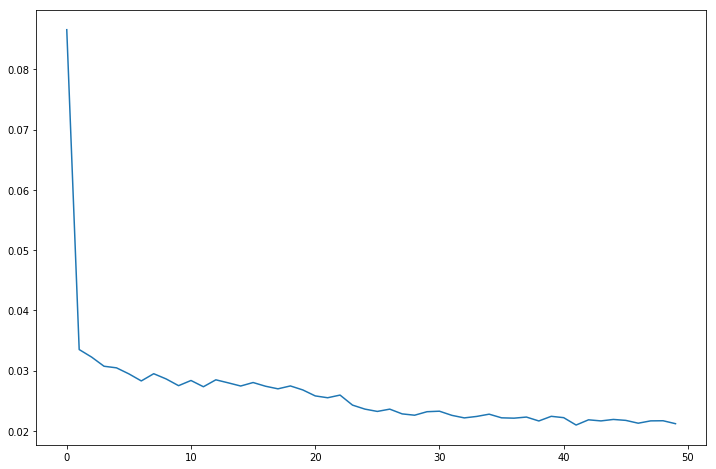

In [10]:
plt.figure(figsize=(12,8))
plt.plot(hist.epoch,hist.history['loss'],label='Test')
plt.plot(hist.epoch,hist.history['val_loss'],label='Validation',linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend()
plt.show()

### Model Predict

In [11]:
# Load best model weights
from keras.models import load_model
model = load_model('tmp/weights.hdf5')

OSError: Unable to open file (unable to open file: name = 'tmp/weights.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [12]:
def TestBatchGenerator(getter):
    while 1:
        for f in getter.test_images_paths:
            X_train = process_images([getter.test_path + '/' + fname for fname in [f]])
            yield (X_train)

predictions = model.predict_generator(TestBatchGenerator(fetcher),
                       val_samples = len(fetcher.test_images_paths),
                        max_q_size = 32,)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if __name__ == '__main__':
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `predict_generator` call to the Keras 2 API: `predict_generator(<generator..., steps=600, max_queue_size=32)`
  if __name__ == '__main__':
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # Remove the CWD from sys.path while we load

In [13]:
predictions.shape

(600, 37)

In [14]:
header = open('all_zeros_benchmark.csv','r').readlines()[0]

with open('submission_1.csv','w') as outfile:
    outfile.write(header)
    for i in range(len(fetcher.test_images_paths)):
        id_ = (fetcher.get_id(fetcher.test_images_paths[i]))
        pred = predictions[i]
        outline = id_ + "," + ",".join([str(x) for x in pred])
        outfile.write(outline + "\n")

FileNotFoundError: [Errno 2] No such file or directory: 'all_zeros_benchmark.csv'